## Generating Simulated Deformation Events

Simulated Deformation Events are modeled from a finite rectanglar source using the method from: Okada, Surface deformation due to shear and tensile faults in a half-space.

Okada's Paper:  https://www.bosai.go.jp/e/pdf/Okada_1985_BSSA.pdf <br>
Original Basis: https://github.com/matthew-gaddes/SyInterferoPy

### Imports

In [1]:
#@title
!pip install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-2m4b99ox
  Running command git clone -q https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-2m4b99ox
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4735 sha256=604f611497797d0ef95577cd96fcffe0c2ffd71ae502b32c9de747d656128e17
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqgg_60m/wheels/42/f1/aa/a01cebc65547819ce7e859ed78b46258e145fd7cdc29147efd
Successfully built perlin-numpy


In [2]:
#@title
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(16,8)

def display_two_images(unwrapped, wrapped):
    fig, [axs_unwrapped, axs_wrapped] = plt.subplots(1, 2)

    axs_unwrapped.set_title("Unwrapped")
    axs_wrapped.set_title("Wrapped")

    axs_unwrapped.imshow(unwrapped, cmap='jet')
    axs_wrapped.imshow(wrapped, cmap='jet')

def display_three_images(unwrapped, wrapped, masked):
    fig, [axs_unwrapped, axs_wrapped, axs_masked] = plt.subplots(1, 3)

    axs_unwrapped.set_title("Unwrapped")
    axs_wrapped.set_title("Wrapped")
    axs_masked.set_title("Mask")

    axs_unwrapped.imshow(unwrapped, cmap='jet')
    axs_wrapped.imshow(wrapped, cmap='jet')
    axs_masked.imshow(masked, cmap='jet')

In [3]:
#@title
#@sarsim.py
"""
 Created By:   Andrew Player
 File Name:    sarsim.py
 Date Created: 07-2022
 Description:  Functions for simulated-deformation interferogram generation for R&D purposes.
 Credits:      Functions taken from https://github.com/matthew-gaddes/SyInterferoPy
"""

import numpy as np

from time import perf_counter

from perlin_numpy import generate_perlin_noise_2d

class Okada():

    """
    Class that models surface deformation.

    Based off of:

    https://github.com/matthew-gaddes/SyInterferoPy

    and

    Okada, Surface deformation due to shear and tensile faults in a half-space,
    Bulletin of the Seismological Society of America (1985): 1135-1154
    """

    def __init__(self, source, source_xy_m, tile_size, **kwargs):
        
        np.seterr(divide='ignore')

        self.source_type = source
        self.source_x    = source_xy_m[0]
        self.source_y    = source_xy_m[1]
        self.tile_size   = tile_size
        self.params      = kwargs

        self.gen_coordiantes()

        self.los_vector  = np.array(
            [
                [ 0.38213591],
                [-0.08150437],
                [ 0.92050485]
            ]
        )

        # Lames Constants and Poisson Ratio
        self.lames_mu     = 2.3e10 # μ
        self.lames_lambda = 2.3e10 # λ
        self.nu           = self.lames_lambda / (2 * (self.lames_lambda + self.lames_mu)) # Poisson Ratio: ν

        self.length = kwargs['length']
        self.strike = np.deg2rad(kwargs['strike'])

        # δ
        self.dip    = np.deg2rad(kwargs['dip'])

        # Parameters Depending on Type of Event
        if source == 'quake':
            self.opening = 0
            self.slip    = kwargs['slip']
            self.rake    = np.deg2rad(kwargs['rake'])
            self.width   = kwargs['bottom_depth'] - kwargs['top_depth']
            self.depth   = np.mean((kwargs['bottom_depth'], kwargs['top_depth']))

        elif source == 'dyke':
            self.opening = kwargs['opening']
            self.slip    = 0
            self.rake    = np.deg2rad(0)
            self.width   = kwargs['bottom_depth'] - kwargs['top_depth']
            self.depth   = np.mean((kwargs['bottom_depth'], kwargs['top_depth']))

        elif source == 'sill':
            self.opening = kwargs['opening']
            self.slip    = 0
            self.rake    = np.deg2rad(0)
            self.depth   = kwargs['depth']
            self.width   = kwargs['width']

        else:
            raise Exception(f"'Source' must be either 'quake', 'dyke', or 'sill', but is set to {source}.  Exiting.")

        # Components in North and East Directions
        self.east  = self.grid_x - self.source_x + np.cos(self.strike) * np.cos(self.dip) * (self.width / 2)
        self.north = self.grid_y - self.source_y - np.sin(self.strike) * np.cos(self.dip) * (self.width / 2)

        # ξ is okada_x
        self.okada_x = np.cos(self.strike) * self.north + np.sin(self.strike) * self.east + (self.length / 2)
        self.okada_y = np.sin(self.strike) * self.north - np.cos(self.strike) * self.east + (np.cos(self.dip) * self.width) 

        self.d   = self.depth + np.sin(self.dip) * (self.width / 2)
        self.q   = (self.okada_y * np.sin(self.dip)) - (self.d * np.cos(self.dip))

        # η
        self.eta = (self.okada_y * np.cos(self.dip)) + (self.d * np.sin(self.dip))

        self.compute_I_components()

        self.U1 = np.cos(self.rake) * self.slip
        self.U2 = np.sin(self.rake) * self.slip
        self.U3 = self.opening

        self.compute_displacement()


    def gen_coordiantes(self):

        x_axis, y_axis = np.meshgrid(          # Coordinate Axes
            np.arange(0, self.tile_size) * 90, # ((45990 * (self.tile_size / 512)) / (self.tile_size - 1)), # 90m/pixel in x direction
            np.arange(0, self.tile_size) * 90  # ((45990 * (self.tile_size / 512)) / (self.tile_size - 1)) # 90m/pixel in y direction
        )

        y_axis    = np.flipud(y_axis)

        ij_bases  = np.vstack(             # Coordinate System Basis i and j
            (np.ravel(x_axis)[np.newaxis],
             np.ravel(y_axis)[np.newaxis])
        )

        ijk_bases = np.vstack(             # Coordinate System Basis i, j, and k
            (ij_bases,
            np.zeros((1, ij_bases.shape[1])))
        )

        self.x_axis_shape = x_axis.shape
        self.y_axis_shape = y_axis.shape
        self.grid_x = ijk_bases[0, ]
        self.grid_y = ijk_bases[1,:]


    def chinnery(self, f):
        
        """
        Method of combining the different components of displacement.
        """
        
        return f(0, 0) - f(self.width, 0) - f(0, self.length) + f(self.width, self.length)


    def compute_displacement(self):

        """
        Compute the displacements in all directions from all of the sources and combine them.
        """        

        if self.source_type == 'quake':
            U_1 = (self.U1 / (2*np.pi)) * self.chinnery(self.strike_slip_displacement)
            U_2 = (self.U2 / (2*np.pi)) * self.chinnery(self.dip_slip_displacement)
        else:
            U_1 = 0
            U_2 = 0

        if (self.source_type == 'sill' or self.source_type == 'dyke'):
            U_3 = (self.U3 / (2*np.pi)) * self.chinnery(self.tensile_displacement)
        else:
            U_3 = 0

        okada_array = - U_1 - U_2 + U_3

        displacement_array  = np.zeros((3, self.tile_size * self.tile_size))

        displacement_array[0] = np.sin(self.strike) * okada_array[0] - np.cos(self.strike) * okada_array[1]
        displacement_array[1] = np.cos(self.strike) * okada_array[0] + np.sin(self.strike) * okada_array[1]
        displacement_array[2] = okada_array[2]

        self.displacement = displacement_array

        shapes   = (self.x_axis_shape[0], self.x_axis_shape[1])
        x_grid   = np.reshape(self.displacement[0,], shapes) * self.los_vector[0,0]
        y_grid   = np.reshape(self.displacement[1,], shapes) * self.los_vector[1,0]
        z_grid   = np.reshape(self.displacement[2,], shapes) * self.los_vector[2,0]

        self.los_displacement = (x_grid + y_grid + z_grid)


    def update_params_WL(self, W, L):

        """
        Update various parameters according to the relevant combination of Width and Length. 
        This avoids making these computations more times than is necessary.
        """

        xi  = self.okada_x - L
        eta = self.eta     - W

        self.R = np.sqrt(np.square(xi) + np.square(eta) + np.square(self.q))
        self.X = np.sqrt(np.square(xi) + np.square(self.q))
        self.y_tilda = (eta * np.cos(self.dip)) + (self.q * np.sin(self.dip)) 
        self.d_tilda = (eta * np.sin(self.dip)) - (self.q * np.cos(self.dip))
        
        return xi, eta


    def compute_I_1(self, W, L):

        xi  = self.okada_x - L

        if W != 0 and L != 0:
            I_5 = self.I_5_WL
        elif W != 0:
            I_5 = self.I_5_W
        elif L != 0:
            I_5 = self.I_5_L
        else:
            I_5 = self.I_5

        if np.cos(self.dip) > 10E-8:
            return   (1 - 2 * self.nu) * (-xi / (np.cos(self.dip) * (self.R + self.d_tilda))) - np.tan(self.dip) * I_5
        else:
            return -((1 - 2 * self.nu) / 2) * ((xi * self.q) / np.square((self.R + self.d_tilda)))


    def compute_I_2(self, W, L):

        eta = self.eta     - W       

        if W != 0 and L != 0:
            I_3 = self.I_3_WL
        elif W != 0:
            I_3 = self.I_3_W
        elif L != 0:
            I_3 = self.I_3_L
        else:
            I_3 = self.I_3

        return (1 - 2 * self.nu) * -np.log(self.R + eta) - I_3


    def compute_I_3(self, W, L):

        eta = self.eta     - W       

        if W != 0 and L != 0:
            I_4 = self.I_4_WL
        elif W != 0:
            I_4 = self.I_4_W
        elif L != 0:
            I_4 = self.I_4_L
        else:
            I_4 = self.I_4
        
        if np.cos(self.dip) > 10E-8:
            return  (1 - 2 * self.nu) * ((1 / (np.cos(self.dip))) * (self.y_tilda / (self.R + self.d_tilda)) - np.log(self.R + eta)) + np.tan(self.dip) * I_4
        else:
            return ((1 - 2 * self.nu) / 2) * ((eta / (self.R + self.d_tilda)) + ((self.y_tilda * self.q) / np.square(self.R + self.d_tilda)) - np.log(self.R + eta))


    def compute_I_4(self, W, L):

        eta = self.eta     - W       


        if np.cos(self.dip) > 10E-8:
            return  (1 - 2 * self.nu) * (1 / np.cos(self.dip)) * (np.log(self.R + self.d_tilda) - np.sin(self.dip) * np.log(self.R + eta))
        else:
            return -(1 - 2 * self.nu) * (self.q / (self.R + self.d_tilda))


    def compute_I_5(self, W, L):
        
        xi  = self.okada_x - L
        eta = self.eta     - W       

        if np.cos(self.dip) > 10E-8:
            a = (eta * (self.X + (self.q * np.cos(self.dip))) + (self.X * (self.R + self.X) * np.sin(self.dip)))
            b = (xi * (self.R + self.X) * np.cos(self.dip))
            return  (1 - 2 * self.nu) * 2 * np.arctan(a / b) / np.cos(self.dip)
        else:
            return -(1 - 2 * self.nu) * ((xi * np.sin(self.dip)) / (self.R + self.d_tilda))


    def compute_I_components(self):  

        """
        Precompute all necessary I components to avoid doing it more than once.
        """

        self.update_params_WL(0, 0)

        self.I_5 = self.compute_I_5(0, 0)
        self.I_4 = self.compute_I_4(0, 0)
        self.I_3 = self.compute_I_3(0, 0)
        self.I_2 = self.compute_I_2(0, 0)
        self.I_1 = self.compute_I_1(0, 0)

        self.update_params_WL(self.width, 0)

        self.I_5_W = self.compute_I_5(self.width, 0)
        self.I_4_W = self.compute_I_4(self.width, 0)
        self.I_3_W = self.compute_I_3(self.width, 0)
        self.I_2_W = self.compute_I_2(self.width, 0)
        self.I_1_W = self.compute_I_1(self.width, 0)

        self.update_params_WL(0, self.length)

        self.I_5_L = self.compute_I_5(0, self.length)
        self.I_4_L = self.compute_I_4(0, self.length)
        self.I_3_L = self.compute_I_3(0, self.length)
        self.I_2_L = self.compute_I_2(0, self.length)
        self.I_1_L = self.compute_I_1(0, self.length)

        self.update_params_WL(self.width, self.length)

        self.I_5_WL = self.compute_I_5(self.width, self.length)
        self.I_4_WL = self.compute_I_4(self.width, self.length)
        self.I_3_WL = self.compute_I_3(self.width, self.length)
        self.I_2_WL = self.compute_I_2(self.width, self.length)
        self.I_1_WL = self.compute_I_1(self.width, self.length)            


    def get_Is(self, W, L):

        """
        Get the I components corresponding to W and L
        """

        if W != 0 and L != 0:
            I_1 = self.I_1_WL
            I_2 = self.I_2_WL
            I_3 = self.I_3_WL
            I_4 = self.I_4_WL
            I_5 = self.I_5_WL
        elif W != 0:
            I_1 = self.I_1_W
            I_2 = self.I_2_W
            I_3 = self.I_3_W
            I_4 = self.I_4_W
            I_5 = self.I_5_W
        elif L != 0:
            I_1 = self.I_1_L
            I_2 = self.I_2_L
            I_3 = self.I_3_L
            I_4 = self.I_4_L
            I_5 = self.I_5_L
        else:
            I_1 = self.I_1
            I_2 = self.I_2
            I_3 = self.I_3
            I_4 = self.I_4
            I_5 = self.I_5

        return I_1, I_2, I_3, I_4, I_5


    def strike_slip_displacement(self, W, L):

        """
        Calculate the displacement in the strike-slip direction.
        """

        xi, eta = self.update_params_WL(W, L)

        I_1, I_2, _, I_4, _ = self.get_Is(W, L)

        q_re  = self.q / (self.R + eta)
        q_rre = (1 / self.R) * q_re
        arctan  = np.arctan((xi * eta) / (self.q * self.R))

        x_direction = (xi * q_rre) + arctan + (I_1 * np.sin(self.dip))
        y_direction = (self.y_tilda * q_rre) + (np.cos(self.dip) * q_re) + (I_2 * np.sin(self.dip))
        z_direction = (self.d_tilda * q_rre) + (np.sin(self.dip) * q_re) + (I_4 * np.sin(self.dip))

        displacements = np.asarray([x_direction, y_direction, z_direction])

        return displacements


    def dip_slip_displacement(self, W, L):

        """
        Calculate the displacement in the dip-slip direction.
        """

        xi, eta = self.update_params_WL(W, L)

        I_1, _, I_3, _, I_5 = self.get_Is(W, L)          

        sc_dip = np.sin(self.dip) * np.cos(self.dip)
        q_rrx  = self.q / (self.R * (self.R + xi))
        arctan   = np.arctan((xi * eta) / (self.q * self.R))

        x_direction = (self.q / self.R) - I_3 * sc_dip
        y_direction = (self.y_tilda * q_rrx) + (np.cos(self.dip) * arctan) - (I_1 * sc_dip)
        z_direction = (self.d_tilda * q_rrx) + (np.sin(self.dip) * arctan) - (I_5 * sc_dip)

        displacements = np.asarray([x_direction, y_direction, z_direction])

        return displacements


    def tensile_displacement(self, W, L):

        """
        Calculate the displacement in the tensile direction.
        """

        xi, eta = self.update_params_WL(W, L)

        I_1, _, I_3, _, I_5 = self.get_Is(W, L)

        s_d    = np.square(np.sin(self.dip))
        q_rre  = self.q / (self.R * (self.R + eta))      
        q_rrx  = self.q / (self.R * (self.R + xi))
        arctan = np.arctan((xi * eta) / (self.q * self.R))
        q_rre_arctan = (xi * q_rre) - arctan

        x_direction =  (self.q * q_rre) - (I_3 * s_d )
        y_direction = -(self.d_tilda * q_rrx) - (np.sin(self.dip) * q_rre_arctan) - (I_1 * s_d)
        z_direction =  (self.y_tilda * q_rrx) + (np.cos(self.dip) * q_rre_arctan) - (I_5 * s_d)

        displacements = np.asarray([x_direction, y_direction, z_direction])

        return displacements


    def print_info(self):

        """
        Print out the event's key parameters.
        """

        print("Event Type               ", self.source_type)
        print("Length         (meters)  ", self.length)
        print("Depth          (meters)  ", self.depth)
        print("Slip           (0  or 1) ", self.slip)
        print("Dip            (degrees) ", self.dip)
        print("Rake           (degrees) ", self.rake)
        print("Strike         (degrees) ", self.strike)
        print("Opening        (meters)  ", self.opening)
        print("Src X Position (meters)  ", self.source_x)
        print("Src Y Position (meters)  ", self.source_y)
        print("Maximum Displacement     ", np.max(np.abs(self.displacement)))
        print("Maximum LOS Displacement ", np.max(np.abs(self.los_displacement)))



def atmosphere_turb(n_atms, lons_mg, lats_mg, mean_m = 0.02, difference = True):
    
    """ A function to create synthetic turbulent atmospheres based on the  methods in Lohman Simons 2005, or using Andy Hooper and Lin Shen's fft method.  
    Note that due to memory issues, when using the covariance (Lohman) method, largers ones are made by interpolateing smaller ones.  
    Can return atmsopheres for an individual acquisition, or as the difference of two (as per an interferogram).  Units are in metres.  
    
    Inputs:
        n_atms | int | number of atmospheres to generate
        lons_mg | rank 2 array | longitudes of the bottom left corner of each pixel.  
        lats_mg | rank 2 array | latitudes of the bottom left corner of each pixel.  
        method | string | 'fft' or 'cov'.  Cov for the Lohmans Simons (sp?) method, fft for Andy Hooper/Lin Shen's fft method (which is much faster).  Currently no way to set length scale using fft method.  
        mean_m | float | average max or min value of atmospheres that are created.  e.g. if 3 atmospheres have max values of 0.02m, 0.03m, and 0.04m, their mean would be 0.03cm.  
        water_mask | rank 2 array | If supplied, this is applied to the atmospheres generated, convering them to masked arrays.  
        difference | boolean | If difference, two atmospheres are generated and subtracted from each other to make a single atmosphere.  
        verbose | boolean | Controls info printed to screen when running.  
        cov_Lc     | float | length scale of correlation, in metres.  If smaller, noise is patchier, and if larger, smoother.  
        cov_interpolate_threshold | int | if n_pixs is greater than this, images will be generated at size so that the total number of pixels doesn't exceed this.  
                                          e.g. if set to 1e4 (10000, the default) and images are 120*120, they will be generated at 100*100 then upsampled to 120*120.  
        
    
    Outputs:
        ph_turbs | r3 array | n_atms x n_pixs x n_pixs, UNITS ARE M.  Note that if a water_mask is provided, this is applied and a masked array is returned.  
        
    2019/09/13 | MEG | adapted extensively from a simple script
    2020/10/02 | MEG | Change so that a water mask is optional.  
    2020/10/05 | MEG | Change so that meshgrids of the longitudes and latitudes of each pixel are used to set resolution. 
                       Also fix a bug in how cov_Lc is handled, so this is now in meters.  
    2020/10/06 | MEG | Add support for rectangular atmospheres, fix some bugs.  
    2020_03_01 | MEG | Add option to use Lin Shen/Andy Hooper's fft method which is quicker than the covariance method.  
    """


    def lon_lat_to_ijk(lons_mg, lats_mg):
        
        """ Given a meshgrid of the lons and lats of the lower left corner of each pixel, 
        find their distances (in metres) from the lower left corner.  
        Inputs:
            lons_mg | rank 2 array | longitudes of the lower left of each pixel.  
            lats_mg | rank 2 array | latitudes of the lower left of each pixel.  
        Returns:
            ijk | rank 2 array | 3x lots.  The distance of each pixel from the lower left corner of the image in metres.  
            pixel_spacing | dict | size of each pixel (ie also the spacing between them) in 'x' and 'y' direction.  
        History:
            2020/10/01 | MEG | Written 
        """

        from geopy import distance

        ny, nx = lons_mg.shape

        pixel_spacing = {}
        pixel_spacing['x'] = distance.distance((lats_mg[-1,0], lons_mg[-1,0]), (lats_mg[-1,0], lons_mg[-1,1])).meters
        pixel_spacing['y'] = distance.distance((lats_mg[-1,0], lons_mg[-1,0]), (lats_mg[-2,0], lons_mg[-1,0])).meters

        X, Y = np.meshgrid(pixel_spacing['x'] * np.arange(0, nx), pixel_spacing['y'] * np.arange(0, ny))
        Y = np.flipud(Y)

        ij  = np.vstack((np.ravel(X)[np.newaxis], np.ravel(Y)[np.newaxis]))
        ijk = np.vstack((ij, np.zeros((1, ij.shape[1]))))

        return ijk, pixel_spacing


    def generate_correlated_noise_fft(
        nx,
        ny,
        std_long,
        sp
    ):

        """ A function to create synthetic turbulent troposphere delay using an FFT approach. 
        The power of the turbulence is tuned by the weather model at the longer wavelengths.
        
        Inputs:
            nx (int) -- width of troposphere 
            Ny (int) -- length of troposphere 
            std_long (float) -- standard deviation of the weather model at the longer wavelengths. Default = ?
            sp | int | pixel spacing in km
            
        Outputs:
            APS (float): 2D array, Ny * nx, units are m.
            
        History:
            2020_??_?? | LS | Adapted from code by Andy Hooper.  
            2021_03_01 | MEG | Small change to docs and inputs to work with SyInterferoPy
        """

        np.seterr(divide='ignore')

        cut_off_freq = 1 / 50

        x, y   = np.arange(0, int(nx / 2)), np.arange(0, int(ny / 2))

        freq_x = np.divide(x, nx * sp)
        freq_y = np.divide(y, ny * sp)

        Y, X   = np.meshgrid(freq_x, freq_y)

        freq   = np.sqrt((X * X + Y * Y) / 2)

        ix            = freq < 2/3
        log_power     = np.log10(freq) * -11/3
        log_power[ix] = np.log10(freq[ix]) * -8/3 -np.log10(2/3)

        ix            = freq < cut_off_freq
        bin_power     = np.power(10, log_power)
        bin_power[ix] = 0

        APS_power = np.zeros((ny,nx))

        APS_power[0:int(ny / 2)      , 0:int(nx / 2)        ] = bin_power
        APS_power[0:int(ny / 2)      , int(np.ceil(nx / 2)):] = np.fliplr(bin_power)
        APS_power[int(np.ceil(ny/2)):, 0:int(nx / 2)        ] = np.flipud(bin_power)
        APS_power[int(np.ceil(ny/2)):, int(np.ceil(nx/2))  :] = np.fliplr(np.flipud(bin_power))

        APS_filt = np.sqrt(APS_power)

        x      = np.random.randn(ny, nx)
        y_tmp  = np.fft.fft2(x)
        y_tmp2 = np.multiply(y_tmp, APS_filt)
        y      = np.fft.ifft2(y_tmp2)

        APS = np.real(y)
        APS = APS / np.std(APS) * std_long
        APS = APS * 0.01

        return APS 


    def rescale_atmosphere(
        atm,
        atm_mean = 0.02,
        atm_sigma = 0.005
    ):

        """ a function to rescale a 2d atmosphere with any scale to a mean centered
        one with a min and max value drawn from a normal distribution.  
        Inputs:
            atm | rank 2 array | a single atmosphere.  
            atm_mean | float | average max or min value of atmospheres that are created, in metres.  e.g. if 3 atmospheres have max values of 0.02m, 0.03m, and 0.04m, their mean would be 0.03m
            atm_sigma | float | standard deviation of Gaussian distribution used to generate atmosphere strengths.  
        Returns:
            atm | rank 2 array | a single atmosphere, rescaled to have a maximum signal of around that set by mean_m
        History:
            20YY/MM/DD | MEG | Written
            2020/10/02 | MEG | Standardise throughout to use metres for units.  
        """

        atm -= np.mean(atm)
        
        atm_strength = (atm_sigma * np.random.randn(1)) + atm_mean
        
        if np.abs(np.min(atm)) > np.abs(np.max(atm)):
            atm *= (atm_strength / np.abs(np.min(atm)))
        else:
            atm *= (atm_strength / np.max(atm))
        
        return atm


    ny, nx = lons_mg.shape

    ph_turbs = np.zeros((n_atms, ny, nx))
    _, pixel_spacing = lon_lat_to_ijk(lons_mg, lats_mg)

    for i in range(n_atms):
        ph_turbs[i,:,:] = generate_correlated_noise_fft(
            nx, 
            ny,
            std_long = 1, 
            sp       = 0.001 * np.mean((pixel_spacing['x'], pixel_spacing['y']))
        )

    ph_turbs_m = np.zeros(ph_turbs.shape)
    for atm_n, atm in enumerate(ph_turbs):
        ph_turbs_m[atm_n,] = rescale_atmosphere(atm, mean_m)

    ph_turbs_m = ph_turbs_m[:,:lons_mg.shape[0],:lons_mg.shape[1]]

    return ph_turbs_m


def generate_perlin(
    size: int
) -> np.ndarray:

    """
    Generate an array with perlin noise.

    Parameters:
    -----------
    size : int
        The number of rows/cols.

    Returns:
    --------
    perlin_array : np.ndarray
        The array containing the generated perlin noise.
    
    """

    perlin_array = np.zeros((size, size))
    for j in range(0,3):
        for i in range(4*(2**j), size):
            if size % i == 0:
                res = i
                perlin_array += generate_perlin_noise_2d((size, size), (res, res), (True, True)) * (2**(3-j))
                break
    min = np.amin(perlin_array)
    perlin_array -= min
    return perlin_array


def gen_fake_topo(
    size:          int = 512,
    alt_scale_min: int = 0,
    alt_scale_max: int = 500
):

    """
    Generate fake topography (a dem in meters) for generating simulated atmospheric topographic error.

    Parameters:
    -----------
    size : int
        The size n for the (n, n) dimension array that is returned.
    alt_scale_min : int
        The minimum altitude scaling value for the generated perlin noise.
    alt_scale_max : int
        The maximum altitude scaling value for the generated perlin noise.

    Returns:
    --------
    dem : np.ndarray
        The array that is meant to be used as a simulated dem with values in meters.
    """

    dem = np.zeros((size, size))    
    dem = generate_perlin(dem.shape[0]) * alt_scale_max
    
    neg_indices = dem < np.max(dem) / 1.75
    
    dem[neg_indices] = 0

    non_zero_indices = dem > 0

    dem[non_zero_indices] = dem[non_zero_indices] - np.min(dem[non_zero_indices])

    return dem


def atm_topo_simulate(
    dem_m:         np.ndarray,
    strength_mean: float = 56.0,
    strength_var:  float = 2.0,
):

    """`
    Generate simulated topographic atmospheric error.

    Parameters:
    -----------
    dem_m : np.ndarray
        An array containing either real dem values (in meters) or simulated ones.
    strength_mean : float
        The mean strength/magnitude of the error.
    strength_var : float
        The maximum variation from strength_mean of the magnitude of the error.
    difference : bool
        Whether the error should come from the difference of 2 aquisitions or just 1.

    Returns:
    --------
    ph_turb : np.ndarray
        The array containing the turbulent atmospheric error.
    """

    import numpy as np
    import numpy.ma as ma

    # Sentinel-1 Wavelength in meters
    s1_lambda = 0.0547
    dem_km = 0.001 * dem_m

    ph_topo_aq1 = (strength_mean + strength_var * np.random.randn(1)) * dem_km  # this is the delay for one acquisition
    ph_topo_aq2 = (strength_mean + strength_var * np.random.randn(1)) * dem_km  # and for another
    ph_topo_m   = ((ph_topo_aq1 - ph_topo_aq2)  / (4 * np.pi)) * s1_lambda      # interferogram is the difference, converted from rad to meters

    if np.max(ph_topo_m) < 0:
        ph_topo_m -= np.max(ph_topo_m)
    else:
        ph_topo_m -= np.min(ph_topo_m)

    ph_topo_m  = ma.array(ph_topo_m, mask = ma.getmask(dem_m))
    ph_topo_m -= ma.mean(ph_topo_m)

    return ph_topo_m


def aps_simulate(
    size: int = 512
):

    """
    Generate simulated turbulent atmospheric error.

    Parameters:
    -----------
    size : int
        The size n for the (n, n) dimension array that is returned.

    Returns:
    --------
    ph_turb : np.ndarray
        The array containing the turbulent atmospheric error.
    """

    pixel_size_degs = 1/3600

    scaled_size = pixel_size_degs * size

    lons    = np.arange(0.0, 0.0 + scaled_size, pixel_size_degs)
    lats    = np.arange(0.0, 0.0 + scaled_size, pixel_size_degs)
    
    lons_mg = np.repeat(lons[np.newaxis,:], len(lats),     axis = 0)
    lats_mg = np.repeat(lats[::-1, np.newaxis], len(lons), axis = 1)

    ph_turb = atmosphere_turb(1, lons_mg, lats_mg, mean_m = 0.02)

    return ph_turb[0,]


def coherence_mask_simulate(
    size:      int   = 512,
    threshold: float = 0.3
):

    """
    Generate simulated incoherence to be masked out.

    Parameters:
    -----------
    size : int
        The size n for the (n, n) dimension array that is returned.
    threshold : float
        The maximum value of coherence to be masked to zeros.

    Returns:
    --------
    mask_coh : np.ndarray
        The masked coherence array.
    """

    pixel_size_degs = 1 / 3600
    
    lons = np.arange(0.0, 0.0 + (pixel_size_degs * size), pixel_size_degs)
    lats = np.arange(0.0, 0.0 + (pixel_size_degs * size), pixel_size_degs)
    lons_mg = np.repeat(lons[np.newaxis,:], len(lats), axis = 0)
    lats_mg = np.repeat(lats[::-1, np.newaxis], len(lons), axis = 1)

    mask_coh_values = atmosphere_turb(1, lons_mg, lats_mg, mean_m = 0.01)

    mask_coh_values = (mask_coh_values - np.min(mask_coh_values)) / np.max(mask_coh_values - np.min(mask_coh_values))
    mask_coh = np.where(mask_coh_values > threshold, np.ones(lons_mg.shape), np.zeros(lons_mg.shape)) 

    return mask_coh

# TODO: Try annotations rather than a mask as the training output

def gen_simulated_deformation(
    seed:              int   = 0,
    tile_size:         int   = 512,
    log:               bool  = False,
    atmosphere_scalar: float = 90 * np.pi,
    amplitude_scalar:  float = 1000 * np.pi,
    event_type:        str   = 'quake',
    **kwargs
):

    """
    Generate a wrapped interferogram along with an event-mask from simulated deformation

    Parameters:
    -----------
    seed : int, Optional
        A seed for the random functions. For the same seed, with all other values the same
        as well, the interferogram generation will have the same results. If left at 0,
        the results will be different every time.
    tile_size : int, Optional
        The desired dimensional size of the interferogram pairs. This should match
        the input shape of the model.
    log : bool, Optional
        If true, the function will log various relevant values in the console. 
    atmosphere_scalar : float, Optional
        Scale factor for the intensity of atmospheric noise.
    amplitude_scalar : float, Optional
        Scale factor for the deformation.
    event_type : str, Optional
        The type of deformation event. Can be quake, sill, or dyke.

    Returns:
    --------
    masked_grid : np.ndarray(shape=(tile_size, tile_size))
        An array representing a mask over the simulated deformation which simulates masking an event.
    wrapped_grid : np.ndarray(shape=(tile_size, tile_size)
        The wrapped interferogram.
    presence : [1] or [0]
        [1] if the image contains an event else [0]
    """

    if seed != 0: np.random.seed(seed)

    presence    = np.asarray([1])

    masked_grid = np.zeros((tile_size, tile_size)) 

    random_nums = np.random.rand(13)

    axes_max = (tile_size) * 90

    if not kwargs:

        source_x = axes_max // ((random_nums[0] * 10) + 1)
        source_y = axes_max // ((random_nums[1] * 10) + 1)

        length    = 1000 + 2000 * random_nums[2]
        top_depth = 3000  + 5000 * random_nums[3]
        depth     = 1000 + ((axes_max // 32 ) * random_nums[4])
        width     = 500  + 500 + 1000 * random_nums[5]

        kwargs = {
            'strike'      : 180 * random_nums[6],
            'dip'         : [45, 45][int(random_nums[7] < 0.5)],
            'length'      : length,
            'rake'        : [-90, -90][int(random_nums[7] < 0.5)],
            'slip'        : 1,
            'top_depth'   : top_depth,
            'bottom_depth': top_depth + (top_depth * 2 + 10000 * random_nums[8]),
            'width'       : width,
            'depth'       : depth,
            'opening'     : 1
        }

    else:

        top_depth = kwargs['top_depth']
        source_x  = kwargs['source_x']
        source_y  = kwargs['source_y']
        length    = kwargs['length']

    from time import perf_counter

    start = perf_counter()
    Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)
    end   = perf_counter()

    los_grid = Event.los_displacement * amplitude_scalar * [-1, -1][int(random_nums[7] < 0.5)]

    masked_indices    = los_grid >= np.pi * 2
    n_masked_indices  = los_grid <  np.pi * 2
    no_masked_indices = los_grid <  np.pi * 2

    los_grid[no_masked_indices] = 0
    masked_grid[masked_indices] = 1

    atmosphere_phase = aps_simulate(tile_size) * atmosphere_scalar

    coherence_mask     = coherence_mask_simulate(tile_size, threshold=random_nums[8]*0.3)
    coh_masked_indices = coherence_mask[0,0:tile_size, 0:tile_size] == 0

    interferogram = los_grid + atmosphere_phase[0:tile_size, 0:tile_size]
 
    n_masked_indices   = np.abs(interferogram) <  np.pi * 3
    n_masked_indices2  = np.abs(interferogram) <  np.pi * 5
    masked_grid[masked_indices]        = 1
    # masked_grid[n_masked_indices2]     = 0.5
    masked_grid[n_masked_indices]      = 0
    # masked_grid[coh_masked_indices]    = 0
    interferogram[coh_masked_indices]  = 0

    wrapped_grid = np.angle(np.exp(1j * (interferogram)))

    zeros = wrapped_grid == 0
    wrapped_grid += np.pi
    wrapped_grid /= (2 * np.pi)
    wrapped_grid[zeros] = 0

    if log:
        print("__________\n")
        print(event_type)
        print("__________\n")
        print("Length         (meters)  ", length)
        print("Top Depth      (meters)  ", top_depth)
        print("Bottom Depth   (meters)  ", kwargs['bottom_depth'])
        print("Depth          (meters)  ", kwargs['depth'])
        print("")
        print("Slip           (0  or 1) ", kwargs['slip'])
        print("Dip            (degrees) ", kwargs['dip'])
        print("Rake           (degrees) ", kwargs['rake'])
        print("Strike         (degrees) ", kwargs['strike'])
        print("Opening:       (meters)  ", kwargs['opening'])
        print("")
        print("Max X Position (meters)  ", axes_max)
        print("Max Y Position (meters)  ", axes_max)
        print("Src X Position (meters)  ", source_x)
        print("Src Y Position (meters)  ", source_y)
        print("")
        print("Maximum Phase Value:     ", np.max(np.abs(interferogram)))
        print("")
        print("Compute Time   (seconds) ", end - start)
        print("__________\n")

    unwrapped = Event.los_displacement * amplitude_scalar + atmosphere_phase[0:tile_size, 0:tile_size]

    return unwrapped, masked_grid, wrapped_grid, presence


def gen_gaussian_noise(
    seed:        int   = 0,
    tile_size:   int   = 512,
    noise_level: float = 90 * np.pi,
    threshold:   float = 90 * np.pi / 4
):

    if seed != 0: 
        np.random.seed(seed)

    noise_grids = np.random.uniform(-noise_level, noise_level, size=(2, tile_size, tile_size))

    inconsistancy = np.abs(noise_grids[1]) >= threshold

    noise_grids[1][inconsistancy] = 0

    index = noise_grids[1] == 0
    noise_grids[0][index] = 0 

    return noise_grids[0]


def gen_sim_noise(
    seed:              int   = 0,
    tile_size:         int   = 512,
    gaussian_only:     bool  = False,
    atmosphere_scalar: float = 200 * np.pi,
):

    """
    Generate a wrapped interferogram along with an event-mask simulating a noisy interferogram with no deformation.

    Parameters:
    -----------
    seed : int, Optional
        A seed for the random functions. For the same seed, with all other values the same
        as well, the interferogram generation will have the same results. If left at 0,
        the results will be different every time.
    tile_size : int, Optional
        The desired dimensional size of the interferogram pairs. This should match
        the input shape of the model.
    log : bool, Optional
        If true, the function will log various relevant values in the console.
    atmosphere_scalar : float, Optional
        Scale factor for the intensity of atmospheric noise.

    Returns:
    --------
    masked_grid : np.ndarray(shape=(tile_size, tile_size))
        An array representing a mask over the simulated deformation which simulates masking an event.
    wrapped_grid : np.ndarray(shape=(tile_size, tile_size)
        The wrapped interferogram.
    presence : [1] or [0]
        [1] if the image contains an event else [0]
    """

    if seed != 0: np.random.seed(seed)

    presence = np.asarray([0])

    if gaussian_only:

        threshold         = 90 * np.pi
        noise_grid_full   = gen_gaussian_noise(seed, tile_size, threshold=threshold)

        noise_grid_inconsistent = gen_gaussian_noise(seed, tile_size, threshold=(threshold * np.random.random() / 2))

        threshold       = np.random.random() / 2
        coherence_mask  = coherence_mask_simulate(tile_size, threshold=threshold)
        coh_indices     = coherence_mask[0, 0:tile_size, 0:tile_size] == 0

        noise_grid              = noise_grid_full
        noise_grid[coh_indices] = noise_grid_inconsistent[coh_indices]

        wrapped_grid = np.angle(np.exp(1j * (noise_grid)))

        masked_grid  = np.zeros((tile_size, tile_size))
        phase        = masked_grid

    else:

        simulated_topography = gen_fake_topo(
            size          = tile_size,
            alt_scale_min = 0,
            alt_scale_max = 50
        )

        turb_phase = aps_simulate(tile_size) * atmosphere_scalar / 8
        topo_phase = aps_simulate(tile_size) * atmosphere_scalar + np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * np.pi)

        threshold       = np.random.random() / 2
        coherence_mask  = coherence_mask_simulate(tile_size, threshold=threshold)
        coh_indices     = coherence_mask[0, 0:tile_size, 0:tile_size] == 0

        phase = turb_phase + topo_phase

        wrapped_grid = np.angle(np.exp(1j * (phase)))
        wrapped_grid[coh_indices] = 0

        masked_grid = np.zeros((tile_size, tile_size))

    zeros = wrapped_grid == 0
    wrapped_grid += np.pi
    wrapped_grid /= (2 * np.pi)
    wrapped_grid[zeros] = 0

    return phase, masked_grid, wrapped_grid, presence

#### Input Parameters and Keyword Arguments

In [4]:
seed       =  0       # 0 seed here means random atmospheric noise every time the function is called.
tile_size  =  512
event_type = 'quake'

source_x = 20000  # min_x, max_x is 0->45000 at (512, 512)
source_y = 20000  # min_y, max_y is 0->45000 at (512, 512)

kwargs = {
    'strike'      : 180,        # for source_type 'quake'
    'dip'         : 45,         # for source_type 'quake'
    'length'      : 4000,       # for source_type 'quake'
    'rake'        : 90,         # for source_type 'quake'
    'slip'        : 2,          # for source_type 'quake'
    'top_depth'   : 4000,       # for source_type 'quake'
    'bottom_depth': 8000,       # for source_type 'quake'
    'width'       : 2000,       # for source_type 'sill' and 'dyke'
    'depth'       : 4000,       # for source_type 'sill' and 'dyke'
    'opening'     : 0.5,        # for source_type 'sill' and 'dyke',
    'source_x'    : source_x,
    'source_y'    : source_y
}


#### Generating Simulated Turbulent, Topographic, and Gaussian Noise

Using the gen_sim_noise function, one can generate turbulent atmospheric noise, topographic noise, and gaussian noise tiles. These are currently used as 'negatives' for training purposes. 

Max, Min Noise Values:  16.62962689933551 -12.00054103831212


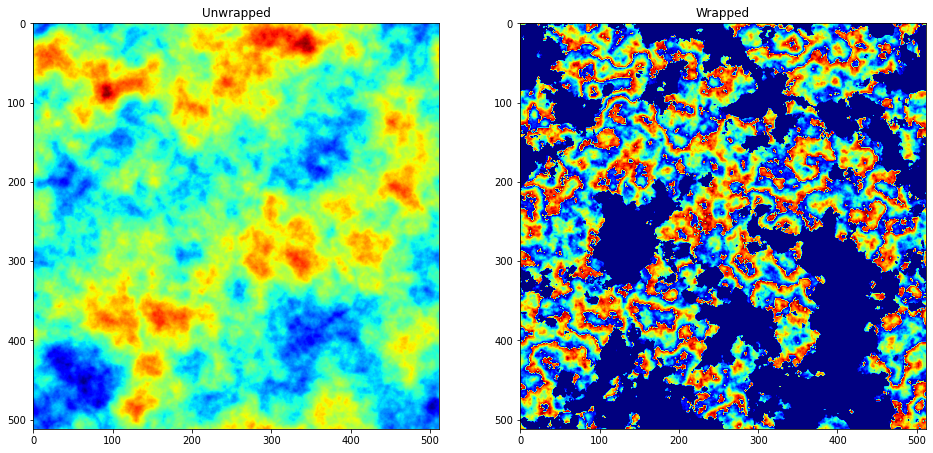

In [5]:
seed              = 123456
tile_size         = 512
gaussian_only     = False       # If no atmospheric noise is desired.
atmosphere_scalar = 200 * np.pi # Again, the 'displacement' needs to be scaled.

unwrapped, masked, wrapped, event_is_present = gen_sim_noise(
    seed              = seed,
    tile_size         = tile_size,
    gaussian_only     = False,
    atmosphere_scalar = 200 * np.pi
)

print("Max, Min Noise Values: ", np.max(unwrapped), np.min(unwrapped))

display_two_images(unwrapped, wrapped)

## Generate Event Manually

If you want to get the actual line-of-sight displacement with no noise or contamination, you can generate a deformation event manually using the Okada class. This requires the basically the same inputs as the gen_simulated_deformation function with kwargs. 

Ultimately, it's purpose is to generate the line-of-sight displacement (self.los_displacement). But it also generates quite of bit of information that you may access:
```python
self.source_type
self.source_x
self.source_y
self.tile_size
self.params
self.x_axis_shape
self.y_axis_shape
self.grid_x
self.grid_y
self.los_vector
self.lames_mu       # μ
self.lames_lambd    # λ
self.nu             # ν (poisson ration)
self.length
self.strike
self.dip            # δ
self.opening
self.slip
self.rake
self.width
self.depth
self.east
self.north
self.okada_x        # ξ
self.okada_y
self.d
self.q
self.eta            # η
self.U1
self.U2
self.U3
self.displacement
self.los_displacement
```

#### Get Displacement and Amplify

Since the model gives us line-of-sight displacement, the values are generally very low and won't even get close to wrapping around pi. Because of this, we need to scale the values for them to be useful for our purposes.

Event Type                quake
Length         (meters)   4000
Depth          (meters)   6000.0
Slip           (0  or 1)  2
Dip            (degrees)  0.7853981633974483
Rake           (degrees)  1.5707963267948966
Strike         (degrees)  3.141592653589793
Opening        (meters)   0
Src X Position (meters)   20000
Src Y Position (meters)   20000
Maximum Displacement      0.20882280246726537
Maximum LOS Displacement  0.19575543005634385


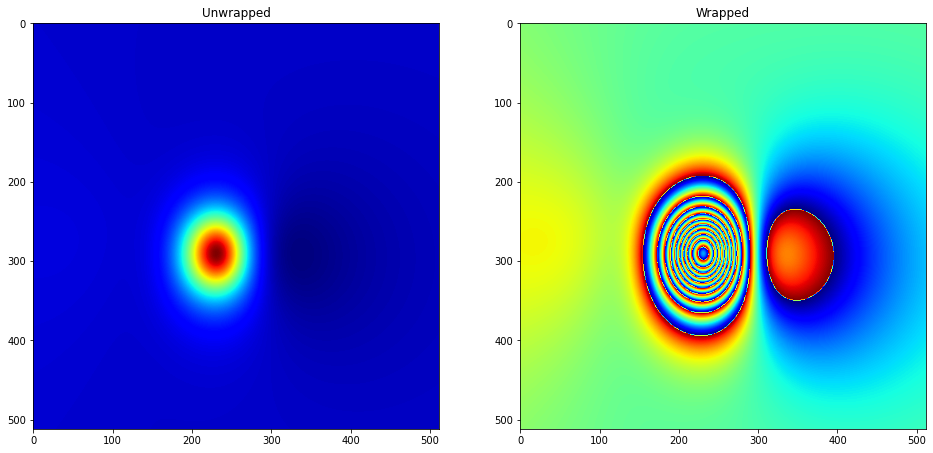

In [6]:
Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)
Event.print_info()

scalar           = 100 * np.pi
los_displacement = Event.los_displacement
phase            = scalar * los_displacement
wrapped_phase    = np.angle(np.exp(1j * (phase)))

display_two_images(phase, wrapped_phase)

## Manually Add Simulated Noise and Error Sources

Currently, there three primary types of error that are supported: turbulant atmospheric error, topographic atmospheric error, and guassian noise. Additionally, it is possible to generate masked areas of incoherence. 

### Static-Like Guassian Noise

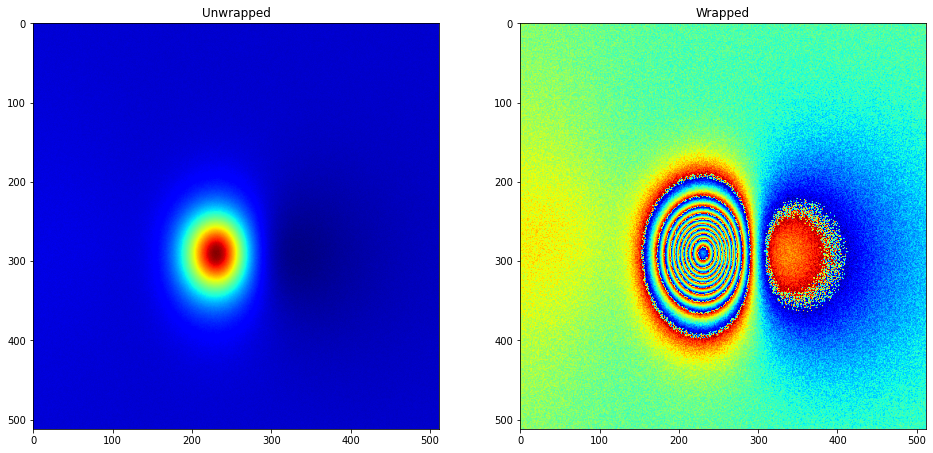

In [7]:
seed        = 0
tile_size   = 512
noise_level = 0.5
threshold   = 0.5
noise_grid  = gen_gaussian_noise(seed, tile_size, noise_level=noise_level, threshold=threshold)

event_with_gaussian = noise_grid + phase

gaussian_wrapped_grid = np.angle(np.exp(1j * (event_with_gaussian)))

display_two_images(event_with_gaussian, gaussian_wrapped_grid)

### Inconsistant Gaussian Noise

Due to limitations in the ability to mask out incoherent areas in interferograms, there can be splotchy blips of of static-like noise. In order to emulate this, two gaussian noise grids are generated. The threshold value is then used with one of the noise grids to determine what noise from the other can make it through. This means that the threshold value should be some fraction of the noise_level value. When the threshold equals the noise_level all noise is let through.

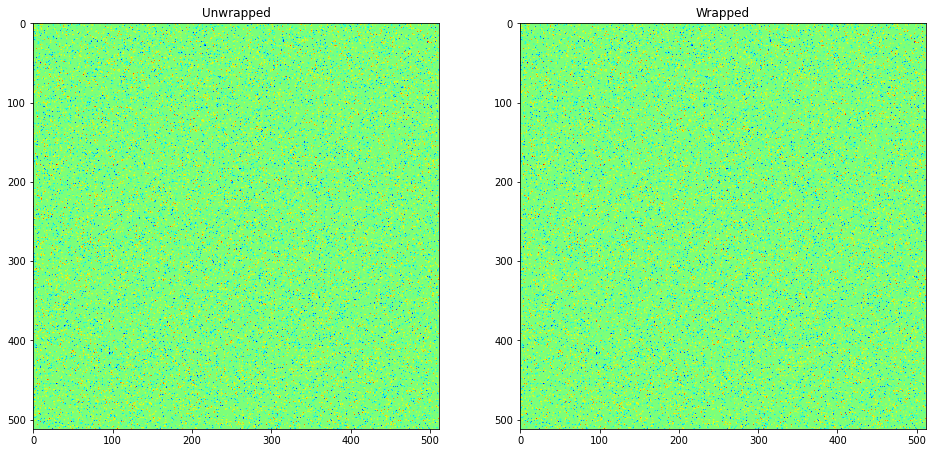

In [8]:
seed        = 0
tile_size   = 512
noise_level = np.pi
threshold   = np.pi / 8
noise_grid  = gen_gaussian_noise(seed, tile_size, noise_level=noise_level, threshold=threshold)

inc_gaussian_wrapped_grid = np.angle(np.exp(1j * (noise_grid)))

display_two_images(noise_grid, inc_gaussian_wrapped_grid)

### Simulated Masked-out Areas of Incoherence

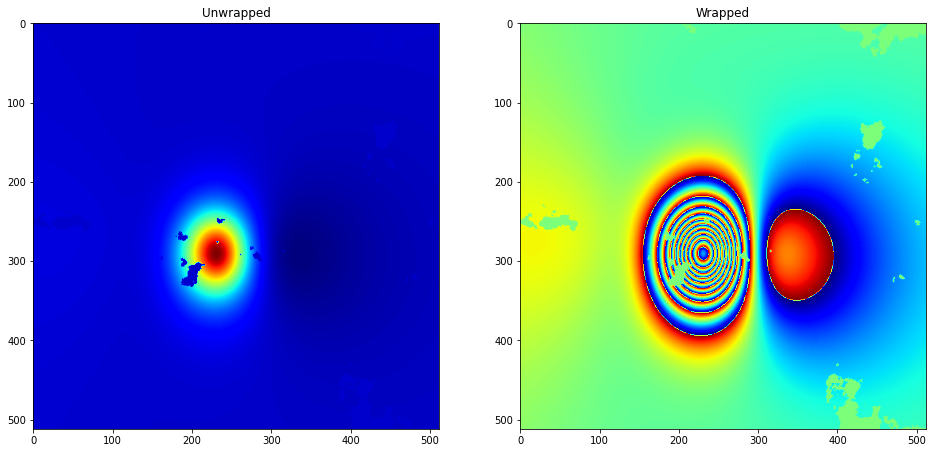

In [9]:
threshold       = 0.2
coherence_mask  = coherence_mask_simulate(tile_size, threshold=threshold)
coh_indices     = coherence_mask[0, 0:tile_size, 0:tile_size] == 0

phase_with_coh_mask              = np.copy(phase)
phase_with_coh_mask[coh_indices] = 0 
wrapped_with_coh_mask            = np.angle(np.exp(1j * phase_with_coh_mask))

display_two_images(phase_with_coh_mask, wrapped_with_coh_mask)

### Turbulant Atmospheric Error

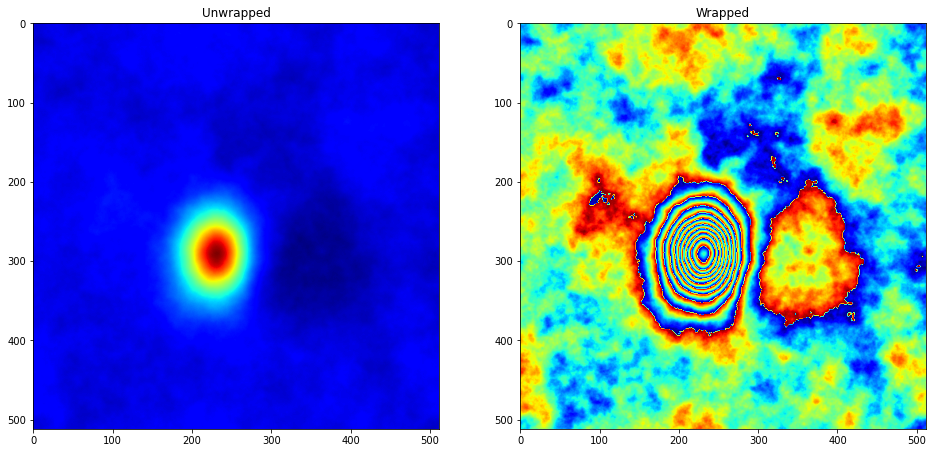

In [10]:
atmosphere_scalar = 100 * np.pi 

turb_phase = aps_simulate(tile_size) * atmosphere_scalar
turb_event_phase = turb_phase + phase
wrapped_turb_phase = np.angle(np.exp(1j * turb_event_phase))

display_two_images(turb_event_phase, wrapped_turb_phase)

### Topographic Atmospheric Error

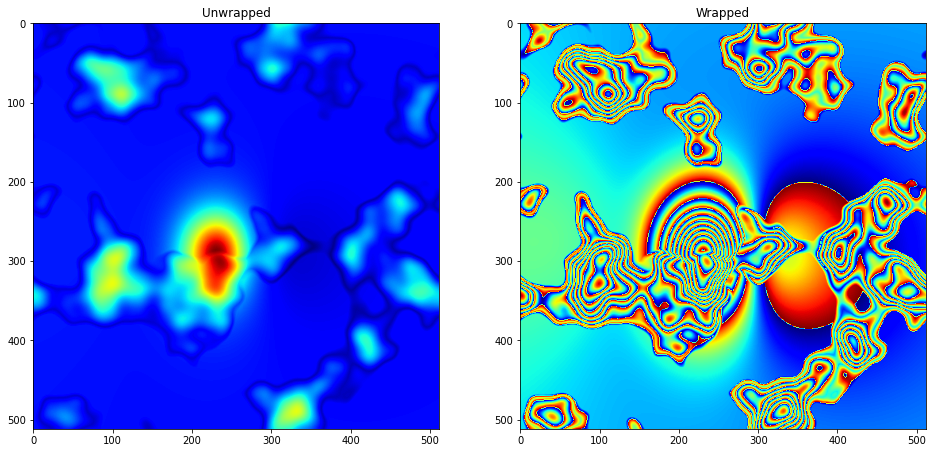

In [11]:
atmospheric_scalar = 100 * np.pi

simulated_topography = gen_fake_topo(
    size          = tile_size
)

topo_phase         = np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * np.pi)
topo_event_phase   = topo_phase + phase
wrapped_topo_phase = np.angle(np.exp(1j * (topo_event_phase)))

display_two_images(topo_event_phase, wrapped_topo_phase)

### Combining All Error Sources

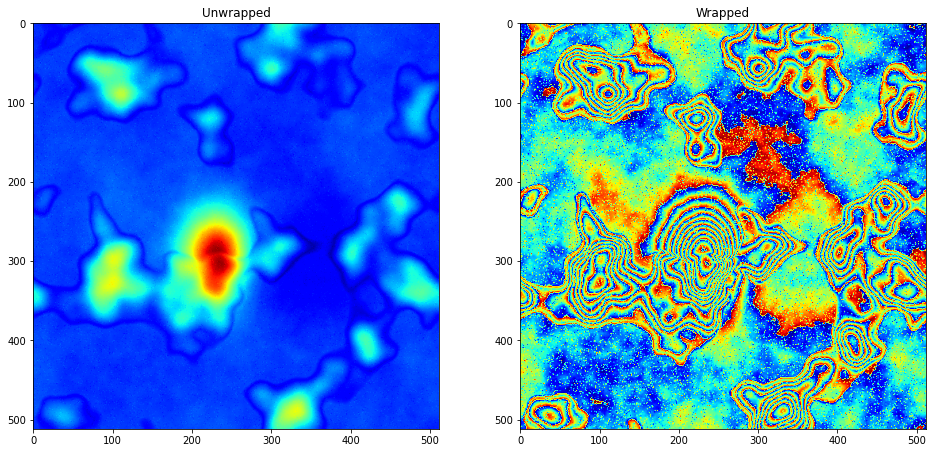

In [12]:
combined_error_phase         = phase + topo_phase + turb_phase + noise_grid
combined_error_wrapped_phase = np.angle(np.exp(1j * combined_error_phase))

display_two_images(combined_error_phase, combined_error_wrapped_phase)

## Generating Training-Optimized Events

Deep Learning models can be extremely robust, and they can learn from deep nuances in data. Like humans, deep learning algorithms learn much more effectively when information is presented in certain ways. This is especially true here! For example, if we allow any possible valid combination to be generated, we may be generating events which don't produce enough deformation to show through the background noise. At best, this would waste space and time, since the model has no information to learn from. At worst, the model could incorrectly learn to identify noise as an event due to the positive label that would be attached. Therefore, gen_simulated_deformation randomly selects parameters from ranges which properly highlight the most important features for identification purposes. Furthermore, a boundary between portions of events is added, and the wrapped images are normalized between 0 and 1.

Events from gen_simulated_deformation are used as the ***positives*** for training purposes.

Events can also be produced with user-provided kwargs if desired.

In [13]:
seed       =  123456
tile_size  =  512
event_type = 'quake'
log        =  True

#### With Kwargs

Including our kwargs will create the event using the specified options. Please note that all of the dict keys need to be present when using kwargs. It is also important to note that there is randomly generated atmospheric noise, using an fft method; thus, if you want the same image every time, you need to use a seed.

__________

quake
__________

Length         (meters)   4000
Top Depth      (meters)   4000
Bottom Depth   (meters)   8000
Depth          (meters)   4000

Slip           (0  or 1)  2
Dip            (degrees)  45
Rake           (degrees)  90
Strike         (degrees)  180
Opening:       (meters)   0.5

Max X Position (meters)   46080
Max Y Position (meters)   46080
Src X Position (meters)   20000
Src Y Position (meters)   20000

Maximum Phase Value:      47.225631269317816

Compute Time   (seconds)  0.1346215629891958
__________



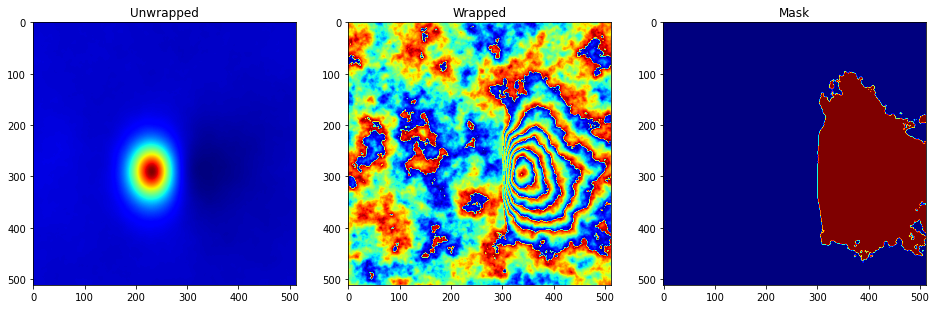

In [14]:
unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed, 
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
    **kwargs
)

display_three_images(unwrapped, wrapped, masked)

#### With Random Parameters

The ranges for the randomly generated parameters do not cover all possible valid combinations; rather, they are set to reliably produce events that are suitible for eventnet's training.

__________

quake
__________

Length         (meters)   1520.9520117315667
Top Depth      (meters)   7486.182621822867
Bottom Depth   (meters)   23689.569308353595
Depth          (meters)   1542.5195913131267

Slip           (0  or 1)  1
Dip            (degrees)  45
Rake           (degrees)  -90
Strike         (degrees)  81.24776468557194
Opening:       (meters)   1

Max X Position (meters)   46080
Max Y Position (meters)   46080
Src X Position (meters)   20302.0
Src Y Position (meters)   4319.0

Maximum Phase Value:      78.10560762583468

Compute Time   (seconds)  0.10501899701193906
__________



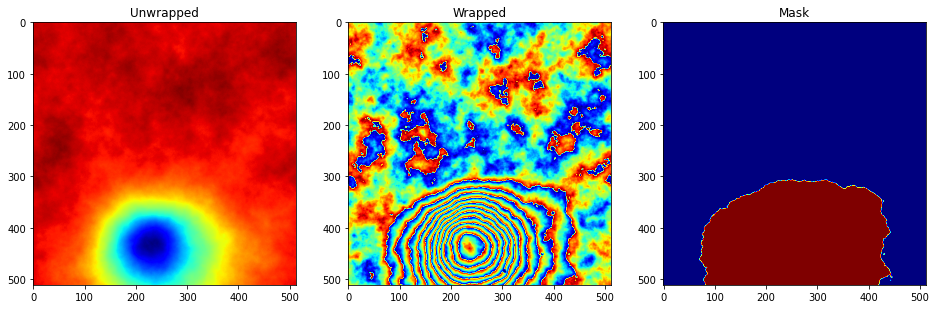

In [15]:
unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed,
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
)

display_three_images(unwrapped, wrapped, masked)

## Randomly Generating Training-Optimized Error

Similar to the images with events, the ***negatives*** also benefit from curation. This is done using the gen_sim_noise function. 

Max, Min Noise Values:  16.62962689933551 -12.00054103831212


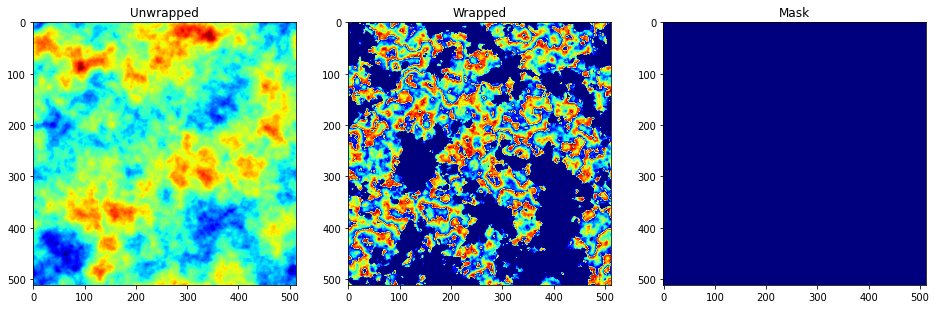

In [16]:
seed              = 123456
tile_size         = 512
gaussian_only     = False       # If no atmospheric noise is desired.
atmosphere_scalar = 200 * np.pi # Again, the 'displacement' needs to be scaled.

unwrapped, masked, wrapped, event_is_present = gen_sim_noise(
    seed              = seed,
    tile_size         = tile_size,
    gaussian_only     = False,
    atmosphere_scalar = 200 * np.pi
)

print("Max, Min Noise Values: ", np.max(unwrapped), np.min(unwrapped))

display_three_images(unwrapped, wrapped, masked)

## Generate Time Series Deformation

In [17]:
# def gen_simulated_time_series(n_interferograms):
    
#     phases = []
#     mask   = np.zeros((tile_size, tile_size))

#     simulated_topography = gen_fake_topo(
#         size          = tile_size
#     )

#     event_type = 'quake'

#     Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)
#     Event.print_info()

#     scalar              = 100 * np.pi
#     los_displacement    = Event.los_displacement
#     phase               = scalar * los_displacement
#     wrapped_phase       = np.angle(np.exp(1j * (phase)))
#     mask[phase > np.pi] = 1 
    
#     for i in range(n_interferograms):
        
#         displacement_step = phase / n_interferograms
        
#         topo_phase         = np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * 0.15 * np.pi)
#         turb_phase         = aps_simulate(tile_size) * atmosphere_scalar * 0.15
        
#         phase_step         = displacement_step + topo_phase + turb_phase
#         wrapped_phase_step = np.angle(np.exp(1j * (phase_step)))

#         phases.append((phase_step, wrapped_phase_step))

#     return phases, mask

def gen_simulated_time_series(
    n_interferograms:  int   = 24,
    tile_size:         int   = 512,
    seed:              int   = 0,
    atmosphere_scalar: float = 90 * np.pi,
    noise_only:        bool  = False
):
    
    """
    Generate a time-series of interferograms with simulated deformation. Correlated by a common dem.

    Parameters:
    -----------
    seed : int, Optional
        A seed for the random functions. For the same seed, with all other values the same
        as well, the interferogram generation will have the same results. If left at 0,
        the results will be different every time.
    tile_size : int, Optional
        The desired dimensional size of the interferogram pairs. This should match
        the input shape of the model.
    log : bool, Optional
        If true, the function will log various relevant values in the console.
    atmosphere_scalar : float, Optional
        Scale factor for the intensity of atmospheric noise.

    Returns:
    --------
    masked_grid : np.ndarray(shape=(tile_size, tile_size))
        An array representing a mask over the simulated deformation which simulates masking an event.
    wrapped_grid : np.ndarray(shape=(tile_size, tile_size)
        The wrapped interferogram.
    presence : [1] or [0]
        [1] if the image contains an event else [0]
    """
    
    if seed != 0: np.random.seed(seed)

    simulated_topography = gen_fake_topo(
        size          = tile_size,
        alt_scale_max = 100
    )

    event_type  = 'quake'
    axes_max    = (tile_size) * 90
    random_nums = np.random.rand(13)
    scalar      = 100 * np.pi
    mask = np.zeros((tile_size, tile_size))

    if not noise_only:

        axes_max = (tile_size) * 90

        source_x = axes_max // ((random_nums[0] * 10) + 1)
        source_y = axes_max // ((random_nums[1] * 10) + 1)

        length    = 1000 + 3000 * random_nums[2]
        top_depth = 6000 + 5000 * random_nums[3]
        depth     = 2000 + 2000 * random_nums[3]
        width     = 2000 + 3000 * random_nums[2]

        kwargs = {
            'strike'      : 180 * random_nums[6],
            'dip'         : [45, 90][int(random_nums[7] < 0.5)],
            'length'      : length,
            'rake'        : [-90, -90][int(random_nums[7] < 0.5)],
            'slip'        : 3,
            'top_depth'   : top_depth,
            'bottom_depth': top_depth + (top_depth * 2 + 10000 * random_nums[8]),
            'width'       : depth / 4,
            'depth'       : depth,
            'opening'     : 5
        }

        if event_type == 'dyke':
            kwargs['dip'] = 90

        Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)

        los_displacement = Event.los_displacement
        
        phase = scalar * los_displacement
        
        mask[np.abs(phase) > np.pi] = 1
        
    else:
        
        los_displacement = np.zeros((tile_size, tile_size))

    phases = np.zeros((24, 2, tile_size, tile_size))

    for i in range(n_interferograms):
        
        displacement_step = los_displacement / n_interferograms
        
        topo_phase         = np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * 0.15 * np.pi)
        turb_phase         = aps_simulate(tile_size) * atmosphere_scalar * 0.3
        
        phase_step         = scalar * displacement_step + topo_phase + turb_phase
        wrapped_phase_step = np.angle(np.exp(1j * (phase_step)))

        phase_step         = (phase_step + np.abs(np.min(phase_step))) / np.max((phase_step + np.abs(np.min(phase_step))))
        
        phases[i] = [phase_step, wrapped_phase_step]

    return phases, mask

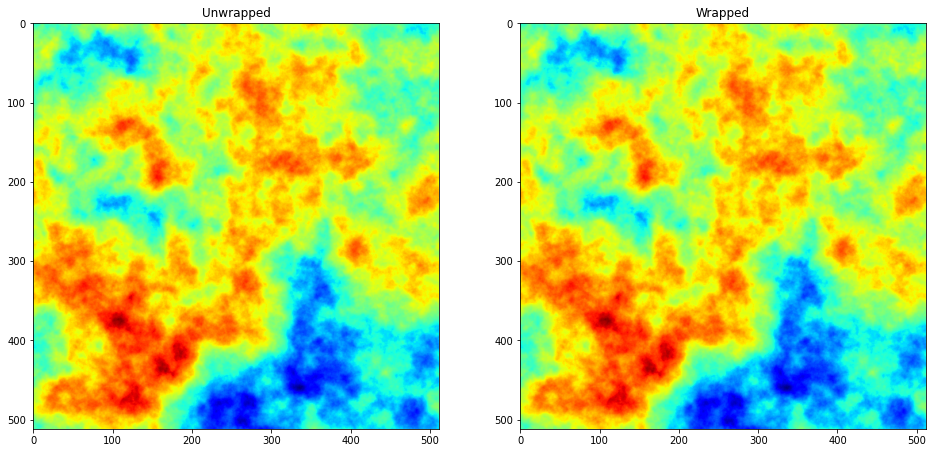

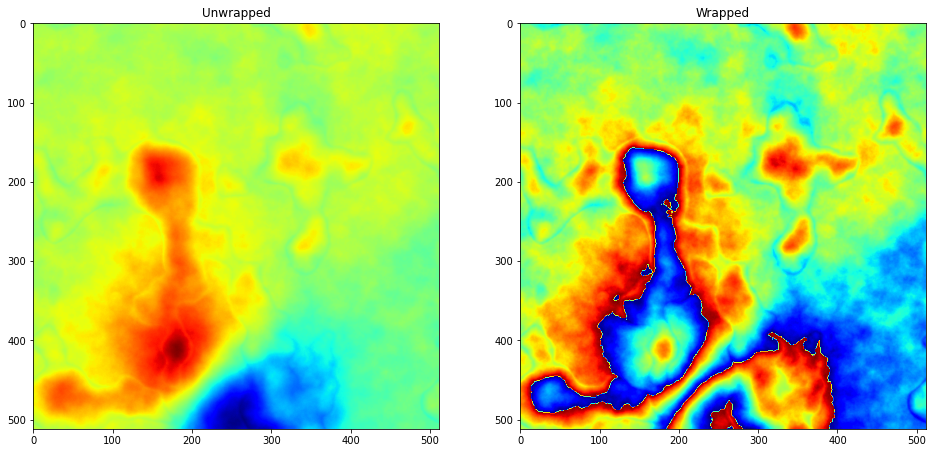

In [18]:
n_interferograms = 24

phases, mask = gen_simulated_time_series(n_interferograms)

phase_accumulation = np.zeros((tile_size, tile_size))

for i in range(n_interferograms):
    
    phase_accumulation   += phases[i, 0, :, :]
    
wrapped_accumulation = np.angle(np.exp(1j * phase_accumulation))

display_two_images(phases[0, 0], phases[0, 1])
display_two_images(phase_accumulation, wrapped_accumulation)

In [19]:
print(np.max(phases[0, 0]))
print(np.min(phases[0, 0]))

1.0
0.0
